In [1]:
#imports and dependencies
import torch
import torch.quantization
# !pip install datasets
from datasets import load_dataset
from torch.utils.data import DataLoader
import random
import multiprocessing
import os
from transformers import AutoTokenizer, AutoModelForCausalLM

# Setup and utilities

In [2]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write

In [3]:
# Load model directly
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-3B-Instruct")
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-3B-Instruct")

tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
#original memory usage for llama 3.2 3b
torch.save(model.state_dict(), "temp.p")
print('Size (MB):', os.path.getsize("temp.p")/1e6)
os.remove('temp.p')

Size (MB): 12851.09892


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cpu'
model.to(device)
print(device)

cuda


In [5]:
class benchmark_dataset(torch.utils.data.Dataset):
  '''formats the data for dataloader'''

  def __init__(self, input, labels, tokenizer, filter_n=150):
    '''constructor. input samples and output labels'''

    self.input = input
    self.labels = labels
    self.tokenizer = tokenizer

    self.filter_len(filter_n)

  def filter_len(self, n):

    new_input = []
    new_label = []

    for q, a in zip(self.input, self.labels):
      tk_len_q = len(tokenizer(str(q), return_tensors='pt')['input_ids'][0])
      tk_len_a = len(tokenizer(str(a), return_tensors='pt')['input_ids'][0])

      if tk_len_q <= n and tk_len_a <= n:
        new_input.append(q)
        new_label.append(a)

    print(f"""
    Len of Original Input: {len(self.input)}
    Len of Original Labels: {len(self.labels)}
    Len of New_Input: {len(new_input)}
    Len of New_Label: {len(new_label)}

    Sample Input, Label: {new_input[0], new_label[0]}

    """)

    self.input = new_input
    self.labels = new_label

  def __len__(self):
    return len(self.input)

  def __getitem__(self, idx):

    return {"question": self.input[idx], "answer": self.labels[idx]}


In [6]:
def format_for_mm(question, choices):
  '''
  Formats questions and choices into one multiple-choice-question string
  '''
  return [f"""Choose the choice that best answer the following question:
  Question:
  {q.strip()}
  Choices:
  {c}
  """
  for q, c in zip(question, choices)]

In [7]:
#to determine the max length of each sample token sequence (below), i'm going to take a quick look
#at the distributions
import matplotlib.pyplot as plt

def plot_data_dist(ds, input=True):
  '''
  plot the token length distribution of inputs in a dataset to understand where to truncate
  bc for qat, i dont have enough memory to feed the entire input
  esp. in a left skew case, which most of these datasets entail, makes sense to cut off the long right tail
  '''
  tk_len = []
  if input:
    for sample in ds:
      tk_len.append(len(tokenizer(str(sample['question']), return_tensors='pt')['input_ids'][0]))

    plt.hist(tk_len)
    plt.show()

  else:
    for sample in ds:
      tk_len.append(len(tokenizer(str(sample['answer']), return_tensors='pt')['input_ids'][0]))

    plt.hist(tk_len)
    plt.show()

  return tk_len #return tk_len as courtesy for further examination if needed

math_tklen = plot_data_dist(math_train)
gpqa_tklen = plot_data_dist(gpqa)
mmlu_tklen = plot_data_dist(mmlu_train)

math_tklen = plot_data_dist(math_train, input=False)
gpqa_tklen = plot_data_dist(gpqa, input=False)
mmlu_tklen = plot_data_dist(mmlu_train, input=False)

NameError: name 'math_train' is not defined

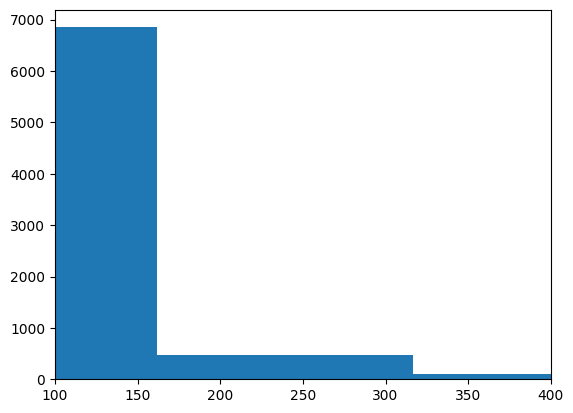

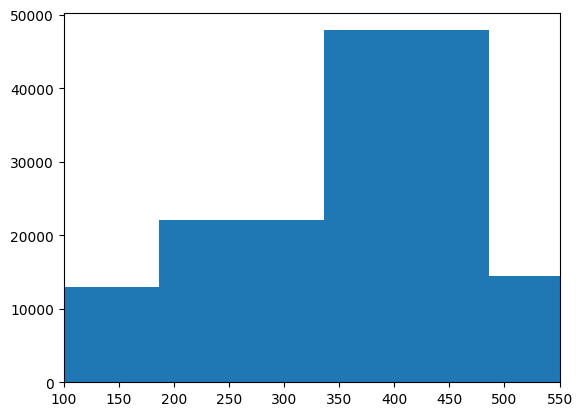

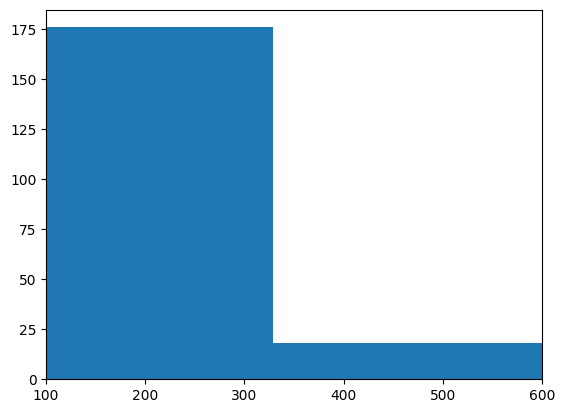

In [41]:
plt.hist(math_tklen)
plt.xlim((100, 400)) #if we zoom in we can see that most samples are within

plt.show()

plt.hist(mmlu_tklen)
plt.xlim((100, 550)) #if we zoom in we can see that most samples are within

plt.show()

plt.hist(gpqa_tklen)
plt.xlim((100, 600)) #if we zoom in we can see that most samples are within

plt.show()

In [8]:
def collate_fn(batch):

    # Now collate into mini-batches
    inputs = tokenizer([i['question'] for i in batch], return_tensors='pt', padding='max_length', truncation=True, max_length=300)
    labels = [i['answer'] for i in batch]

    return {'input_ids': inputs['input_ids'], 'attention_mask': inputs['attention_mask'], 'label': labels}

def collate_fn_qat(batch):

    # Now collate into mini-batches
    inputs = tokenizer([i['question'] for i in batch], return_tensors='pt', padding='max_length', truncation=True, max_length=150)
    # labels = tokenizer([str(i['answer']) for i in batch], return_tensors='pt', padding='max_length', truncation=True, max_length=65)
    labels = tokenizer([str(i['answer']) for i in batch], return_tensors='pt', padding='max_length', truncation=True, max_length=150)

    # labels = [ele[-100:] for ele in labels['input_ids']]

    return {'input_ids': inputs['input_ids'], 'attention_mask': inputs['attention_mask'], 'label': labels['input_ids']}


In [9]:
#CREATE SETS FOR 1) PTQ CALIBRATION/QAT FINETUNING and 2) EVAL

#note: there is no test set for gpqa, so i take a subset of the train set instead (80%), leaving the other subset for testing

#gpqa (for reasoning)
gpqa_raw = load_dataset("Idavidrein/gpqa", "gpqa_diamond")
gpqa_choices = [[a, b, c, d] for a, b, c, d in
                zip(gpqa_raw['train']['Correct Answer'], gpqa_raw['train']['Incorrect Answer 1'],
                    gpqa_raw['train']['Incorrect Answer 2'], gpqa_raw['train']['Incorrect Answer 3'])]
for choices in gpqa_choices:
  random.shuffle(choices)

gpqa_questions_proc = format_for_mm(gpqa_raw['train']['Question'], gpqa_choices)
# gpqa = benchmark_dataset(gpqa_questions_proc, gpqa_raw['train']['Correct Answer'])

# gpqa_dl_train = DataLoader(gpqa[:158], batch_size=64, shuffle=True, collate_fn=collate_fn)
# gpqa_dl_test = DataLoader(gpqa[158:], batch_size=64, shuffle=True, collate_fn=collate_fn)

#math (for math)
math_raw = load_dataset("lighteval/MATH", "all")
# math_train = benchmark_dataset(math_raw['train']['problem'], math_raw['train']['solution'])
# math_dl_train = DataLoader(math_train, batch_size=64, shuffle=True, collate_fn=collate_fn)

# math_test = benchmark_dataset(math_raw['test']['problem'], math_raw['test']['solution'])
# math_dl_test = DataLoader(math_test, batch_size=64, shuffle=True, collate_fn=collate_fn)

# #mmlu (for gen knowledge + reasoning)
mmlu_raw = load_dataset("cais/mmlu", "all")
mmlu_questions_proc_train = format_for_mm(mmlu_raw['auxiliary_train']['question'], mmlu_raw['auxiliary_train']['choices'])
# mmlu_train = benchmark_dataset(mmlu_questions_proc_train, mmlu_raw['auxiliary_train']['answer'])
# mmlu_dl_train = DataLoader(mmlu_train, batch_size=64, shuffle=True, collate_fn=collate_fn)

mmlu_questions_proc_test = format_for_mm(mmlu_raw['test']['question'], mmlu_raw['test']['choices'])
# mmlu_test = benchmark_dataset(mmlu_questions_proc_test, mmlu_raw['test']['answer'])
# mmlu_dl_test = DataLoader(mmlu_test, batch_size=64, shuffle=True, collate_fn=collate_fn)


#master list - train
sublist_input_train = gpqa_questions_proc[:158] + math_raw['train']['problem'] + mmlu_questions_proc_train
sublist_answer_train = gpqa_raw['train']['Correct Answer'][:158] + math_raw['train']['solution'] + mmlu_raw['auxiliary_train']['answer']
agg_train_set = benchmark_dataset(sublist_input_train, sublist_answer_train, tokenizer)

agg_dl_train = DataLoader(agg_train_set, batch_size=4, shuffle=True, collate_fn=collate_fn_qat)

#master list - test
sublist_input_test = gpqa_questions_proc[158:] + math_raw['test']['problem'] + mmlu_questions_proc_test
sublist_answer_test = gpqa_raw['train']['Correct Answer'][158:] + math_raw['test']['solution'] + mmlu_raw['test']['answer']
agg_test_set = benchmark_dataset(sublist_input_test, sublist_answer_test, tokenizer)

agg_dl_test = DataLoader(agg_test_set, batch_size=4, shuffle=True, collate_fn=collate_fn_qat)



    Len of Original Input: 107500
    Len of Original Labels: 107500
    Len of New_Input: 14203
    Len of New_Label: 14203
          
    Sample Input, Label: ("Choose the choice that best answer the following question:\n  Question:\n  Two quantum states with energies E1 and E2 have a lifetime of 10^-9 sec and 10^-8 sec, respectively. We want to clearly distinguish these two energy levels. Which one of the following options could be their energy difference so that they can be clearly resolved?\n  Choices:\n  ['10^-4 eV', '10^-9 eV', '10^-8 eV\\n', '10^-11 eV']\n  ", '10^-4 eV')
    
    

    Len of Original Input: 19082
    Len of Original Labels: 19082
    Len of New_Input: 13706
    Len of New_Label: 13706
          
    Sample Input, Label: ("Choose the choice that best answer the following question:\n  Question:\n  Consider the following metric:\n\nds^{2}=\\frac{32}{\\left(4-x^{2}-y^{2}\\right)}\\left(dx^{2}+dy^{2}\\right)\n\nWhat is the area of the pseudosphere of radius r=2?\

In [10]:
test_check = next(iter(agg_dl_test))

print("Length of Labels")
print(len(test_check['label']))
print("Shape of Input Ids")
print(test_check['input_ids'].shape)
print("Label Sample")
print(test_check['label'][:5]) #quick check on the shapes (printed in the collate function) and samples of the data to ensure that everything looks as expected

Length of Labels
4
Shape of Input Ids
torch.Size([4, 150])
Label Sample
tensor([[128000,     16, 128009, 128009, 128009, 128009, 128009, 128009, 128009,
         128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009,
         128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009,
         128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009,
         128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009,
         128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009,
         128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009,
         128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009,
         128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009,
         128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009,
         128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009,
         128009, 128009, 128009, 1280

### PTQ using torchao

In [11]:
!pip install --upgrade torch torchao
# Install PyTorch, torchvision, torchao nightlies - for hf torch ao integration use
!pip install --pre --upgrade torch torchvision torchao --index-url https://download.pytorch.org/whl/nightly/cu121 # full options are cpu/cu118/cu121/cu124
!pip install --pre --upgrade torchtune --extra-index-url https://download.pytorch.org/whl/nightly/cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 69.5 MB/s eta 0:00:00
Looking in indexes: https://download.pytorch.org/whl/nightly/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 767.9/767.9 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 79.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 85.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 108.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [12]:
import torchao
import copy
from transformers import TorchAoConfig, AutoModelForCausalLM, AutoTokenizer

In [13]:
#subapproach #1 - using torchao directly
from torchao.quantization.quant_api import (
    quantize_,
    int8_dynamic_activation_int8_weight,
    int4_weight_only,
    int8_weight_only
)
model.to(device)
quantize_(model, int8_weight_only())

#double check that we see some expected memory savings
torch.save(model.state_dict(), "temp.p")
print('Size (MB):', os.path.getsize("temp.p")/1e6)
os.remove('temp.p')

Size (MB): 4800.333753


In [14]:
#double check that generation works
input = tokenizer("hello", return_tensors='pt')['input_ids'].to('cuda')
tokenizer.decode(model.generate(input)[0]) #quick test check

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


"<|begin_of_text|>hello! I'm new to this forum and I'm excited to learn and share my knowledge with"

In [15]:
#save the model
model.save_pretrained("./ptq_int8", safe_serialization=False)

In [16]:
#double check that the model can be loaded in
model = AutoModelForCausalLM.from_pretrained("./ptq_int8", device_map="cuda")
model = torch.compile(model, mode="max-autotune")

#and fits the expected memory requirements
torch.save(model.state_dict(), "temp.p")
print('Size (MB):', os.path.getsize("temp.p")/1e6)
os.remove('temp.p')

#double check generatiom works
input = tokenizer("hello", return_tensors='pt')['input_ids'].to('cuda')
tokenizer.decode(model.generate(input)[0]) #quick test check

Size (MB): 4404.79734


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


'<|begin_of_text|>hello everyone, welcome back to my channel. today i want to talk about the importance of self'

In [17]:
#subapproach #2 - using what hf recommends

quantization_config = TorchAoConfig("int4_weight_only", group_size=128)
quantized_model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-3B-Instruct", device_map="auto", quantization_config=quantization_config)

torchao.quantization.utils.recommended_inductor_config_setter()
quantized_model = torch.compile(quantized_model, mode="max-autotune")

quantized_model.save_pretrained("./hf_quant_int4", safe_serialization=False)

loaded_quantized_model = AutoModelForCausalLM.from_pretrained("./hf_quant_int4", device_map="cuda")

loaded_quantized_model = torch.compile(loaded_quantized_model, mode="max-autotune")

Setting torch_dtype to torch.bfloat16 for int4_weight_only quantization since only bfloat16 is supported right now. Please set torch_dtype=torch.bfloat16 to remove this warning.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [18]:
#double check that the quant was applied
# loaded_quantized_model.model.layers[0].self_attn.q_proj.weight.data #we can see that torchao autoquant determined that the best quant approach was to use int8weights

In [19]:
#double check that we see some expected memory savings
torch.save(loaded_quantized_model.state_dict(), "temp.p")
print('Size (MB):', os.path.getsize("temp.p")/1e6)
os.remove('temp.p')

Size (MB): 2285.908892


In [20]:
#double check that generation works
input = tokenizer("hello", return_tensors='pt')['input_ids'].to('cuda')
tokenizer.decode(loaded_quantized_model.generate(input)[0]) #quick test check

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


'<|begin_of_text|>hello = "world"\n\ndef hello_world():\n    global hello\n    print(hello)\n\nhello'

### QAT with torchao

In [13]:
!pip install torchao torchtune #if ptq section was run earlier, no need to pip install again

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.9/686.9 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 79.8 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144555 sha256=243d34073d4cdea9e5a8a1b63a76485a053a149bf78a06a273afd71882130e44
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


In [14]:
#IF PTQ was run before, need a fresh unquant instruct base model again -- otherwise, skip

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-3B-Instruct")
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-3B-Instruct")

tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
import torchao
from torchtune.training.quantization import Int8DynActInt4WeightQATQuantizer
import time

# model.to('cuda')

#prep for quantization
qat_quantizer = Int8DynActInt4WeightQATQuantizer()
model = qat_quantizer.prepare(model)

#hyperparams
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001) #im keeping the lr small bc this is for fine-tuning
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 2
artificial_len = 150

#times to track (key=epoch, value=time in sec)
total_runtime = {}
t_train_time = {}
t_data_time = {}
t_epoch_losses = {}

#training mode
model.train()

###TRAINING LOOP ###
for epoch in range(num_epochs):

  training_time = 0
  dataloading_time = 0
  epoch_loss = 0

  ### START TIMING FOR TOTAL_RUNTIME
  torch.cuda.synchronize()
  start_totalruntime_timer = time.perf_counter()

  ### START DATALOADING TIME
  start_dataloading_timer = time.perf_counter()

  for idx, sample in enumerate(agg_dl_train):

    ### END DATALOADING timer and accumulate total
    dataloading_time += time.perf_counter()-start_dataloading_timer

    inputs = sample['input_ids'][:, :artificial_len].to(device)
    mask = sample['attention_mask'][:, :artificial_len].to(device)
    labels = torch.Tensor(sample['label'][:, :artificial_len]).to(device).long()

    ### START TIMING FOR TRAINING TIME
    torch.cuda.synchronize()
    start_training_timer = time.perf_counter()
    ###

    optimizer.zero_grad()

    outputs = model(inputs, attention_mask=mask, labels=labels)
    loss = outputs.loss

    loss.backward()
    optimizer.step()

    ### END TIMING FOR TRAINING TIME
    torch.cuda.synchronize()
    training_time += time.perf_counter()-start_training_timer

    #print for myself
    if idx%10000 == 0:
      print(f"Epoch {epoch}, Iteration {idx}, Loss: ", loss.item())

    epoch_loss += loss.item()

    #start dataloading timer again for the next batch load
    start_dataloading_timer = time.perf_counter()

  #print for myself (after each epoch)
  print(f"Epoch {epoch}, Loss -- {epoch_loss}")

  #END TIMING FOR TOTAL RUNTIME
  torch.cuda.synchronize()
  total_runtime[epoch] = time.perf_counter()-start_totalruntime_timer

  #log other times
  t_train_time[epoch] = training_time
  t_data_time[epoch] = dataloading_time
  t_epoch_losses[epoch] = epoch_loss

#print stats
print(f"""

total run time: {total_runtime.items()}
train time: {t_train_time.items()}
dataloading time: {t_data_time.items()}

loss/epoch: {t_epoch_losses.items()}

""")

Epoch 0, Iteration 0, Loss:  12.502869606018066
Epoch 0, Loss -- 3370.356109796092
Epoch 1, Iteration 0, Loss:  0.012146401219069958
Epoch 1, Loss -- 3118.979062772356


total run time: dict_items([(0, 1811.076236846), (1, 1810.0278724829996)])
train time: dict_items([(0, 1797.903542860025), (1, 1796.727398568015)])
dataloading time: dict_items([(0, 11.912824163006917), (1, 12.030576425999243)])

loss/epoch: dict_items([(0, 3370.356109796092), (1, 3118.979062772356)])




In [12]:
# Convert fake quantize to actual quantize operations
model = qat_quantizer.convert(model)

In [13]:
#double check that we see some expected memory savings
torch.save(model.state_dict(), "temp.p")
print('Size (MB):', os.path.getsize("temp.p")/1e6)
os.remove('temp.p')

#double check that generation works
input = tokenizer("what is 5*50+6*2", return_tensors='pt')['input_ids'].to('cuda')
tokenizer.decode(model.generate(input, max_new_tokens=200)[0]) #quick test check

#save the model
model.save_pretrained("./qat_int8", safe_serialization=False)

Size (MB): 4889.921905


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


In [14]:
### RELOAD AND CHECK AGAIN ###

#double check that the model can be loaded in
model = AutoModelForCausalLM.from_pretrained("./qat_int8", device_map="cuda")
model = torch.compile(model, mode="max-autotune")

#and fits the expected memory requirements
torch.save(model.state_dict(), "temp.p")
print('Size (MB):', os.path.getsize("temp.p")/1e6)
os.remove('temp.p')

#double check generatiom works
input = tokenizer("hello", return_tensors='pt')['input_ids'].to('cuda')
tokenizer.decode(model.generate(input)[0]) #quick test check

Size (MB): 4483.612316


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


'<|begin_of_text|>hello! the{\\<|eot_id|>'

### PTQ (this attempt didn't work. see above for what works)

In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 7
microcode	: 0xffffffff
cpu MHz		: 2200.144
cache size	: 39424 KB
physical id	: 0
siblings	: 12
core id		: 0
cpu cores	: 6
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp ibrs_enhanced fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat avx512_vnni md_clear arch_capabilities
bugs		: spectre_v1 spectre_v2 spec_store_bypass swapgs ta

In [ ]:
#prep the model for quant
model.qconfig = torch.quantization.get_default_qconfig('x86')
torch.quantization.prepare(model, inplace=True)

/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(
      128256, 3072
      (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
    )
    (layers): ModuleList(
      (0-27): 28 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(
            in_features=3072, out_features=3072, bias=False
            (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
          )
          (k_proj): Linear(
            in_features=3072, out_features=1024, bias=False
            (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
          )
          (v_proj): Linear(
            in_features=3072, out_features=1024, bias=False
            (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
          )
          (o_proj): Linear(
            in_features=3072, out_features=3072, bias=False
            (activation_post_process): HistogramObserver(min_val=inf, max_val=-i

In [ ]:
!nvidia-smi

Tue Dec  3 21:52:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   28C    P0              50W / 400W |  40009MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
def calibrate_model(model, ds):
  '''
  Function to calibrate the model for post training quantization
  '''
  model.eval()
  with torch.no_grad():
    for idx, samples in enumerate(ds):
      input = samples['input_ids'].to(device)
      mask = samples['attention_mask'].to(device)
      model.generate(input, attention_mask=mask, max_new_tokens=10) #both model() and model.generate() should work here bc both involve calling the forward pass

      if idx % 1000 == 0:
        print(f"Count: {idx} ================================================================================== ")

calibrate_model(model, agg_dl_train)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Count: 0 ================================================================================== 


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Settin

Count: 1000 ================================================================================== 


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Settin

In [ ]:
for _, mod in model.named_modules():
    if isinstance(mod, torch.nn.Embedding):
        mod.qconfig = torch.ao.quantization.float_qparams_weight_only_qconfig
quantized_model = torch.quantization.convert(model.to('cpu'), inplace=True)

In [ ]:
torch.save(quantized_model.state_dict(), "temp.p")
print('Size (MB):', os.path.getsize("temp.p")/1e6)
os.remove('temp.p')

Size (MB): 3623.055082


In [ ]:
torch.save(quantized_model.state_dict(), 'quantized_model.pth')
quantized_model.load_state_dict(torch.load('quantized_model.pth'))
quantized_model.eval()

<ipython-input-17-6a61cfe0e0f4>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  quantized_model.load_state_dict(torch.load('quantized_model.pth'))
/usr/local/lib/python3.10

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): QuantizedEmbedding(num_embeddings=128256, embedding_dim=3072, dtype=torch.quint8, qscheme=torch.per_channel_affine_float_qparams)
    (layers): ModuleList(
      (0): LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): QuantizedLinear(in_features=3072, out_features=3072, scale=0.30233249068260193, zero_point=60, qscheme=torch.per_channel_affine)
          (k_proj): QuantizedLinear(in_features=3072, out_features=1024, scale=0.24663104116916656, zero_point=80, qscheme=torch.per_channel_affine)
          (v_proj): QuantizedLinear(in_features=3072, out_features=1024, scale=0.009504689835011959, zero_point=68, qscheme=torch.per_channel_affine)
          (o_proj): QuantizedLinear(in_features=3072, out_features=3072, scale=0.006590045522898436, zero_point=65, qscheme=torch.per_channel_affine)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Quantized

### QAT (this attempt didn't work. see above for what works)

In [ ]:
#prep the model for qat
model.train()
# model.fuse_model()
model.qconfig = torch.quantization.get_default_qat_qconfig('x86')

torch.quantization.prepare_qat(model, inplace=True)


In [ ]:
test_check = next(iter(agg_dl_test))

print("Length of Labels")
print(len(test_check['label']))
print("Shape of Input Ids")
print(test_check['input_ids'].shape)
print("Label Sample")
print(test_check['label'][:5]) #quick check on the shapes (printed in the collate function) and samples of the data to ensure that everything looks as expected

Length of Labels
4
Shape of Input Ids
torch.Size([4, 560])
Label Sample
tensor([[128000,     17, 128009,  ..., 128009, 128009, 128009],
        [128000,     15, 128009,  ..., 128009, 128009, 128009],
        [128000,   1687,   1390,  ..., 128009, 128009, 128009],
        [128000,     16, 128009,  ..., 128009, 128009, 128009]])


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
#train

optimizer = torch.optim.SGD(model.parameters(), lr=0.0001) #im keeping the lr small bc this is for fine-tuning
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 5

model.to(device)

artificial_len = 560

for epoch in range(num_epochs):

  for idx, sample in enumerate(agg_dl_train):

    inputs = sample['input_ids'][:, :artificial_len].to(device)
    mask = sample['attention_mask'][:, :artificial_len].to(device)
    labels = torch.Tensor(sample['label'][:, :artificial_len]).to(device).long()

    optimizer.zero_grad()

    outputs = model(inputs, attention_mask=mask, labels=labels)
    loss = outputs.loss

    if idx%50 == 0:
      print("Loss: ", loss)

    # print(outputs.shape)
    # print(labels.shape)

    # loss = criterion(outputs[:135], labels)

    loss.backward()
    optimizer.step()

# model.eval()

Loss:  tensor(13.2147, device='cuda:0', grad_fn=<NllLossBackward0>)
Loss:  tensor(0.0714, device='cuda:0', grad_fn=<NllLossBackward0>)
Loss:  tensor(1.0061, device='cuda:0', grad_fn=<NllLossBackward0>)
Loss:  tensor(0.0326, device='cuda:0', grad_fn=<NllLossBackward0>)
Loss:  tensor(0.7808, device='cuda:0', grad_fn=<NllLossBackward0>)
Loss:  tensor(0.0481, device='cuda:0', grad_fn=<NllLossBackward0>)
Loss:  tensor(0.0217, device='cuda:0', grad_fn=<NllLossBackward0>)
Loss:  tensor(0.0199, device='cuda:0', grad_fn=<NllLossBackward0>)
Loss:  tensor(0.0166, device='cuda:0', grad_fn=<NllLossBackward0>)
Loss:  tensor(0.0162, device='cuda:0', grad_fn=<NllLossBackward0>)
Loss:  tensor(1.1999, device='cuda:0', grad_fn=<NllLossBackward0>)
Loss:  tensor(0.9100, device='cuda:0', grad_fn=<NllLossBackward0>)
Loss:  tensor(0.0111, device='cuda:0', grad_fn=<NllLossBackward0>)
Loss:  tensor(0.0086, device='cuda:0', grad_fn=<NllLossBackward0>)
Loss:  tensor(0.0080, device='cuda:0', grad_fn=<NllLossBackwa

KeyboardInterrupt: 

In [ ]:
outputs[0].shape

In [ ]:
import copy
model2 = copy.deepcopy(model)

In [ ]:
#convert
for _, mod in model.named_modules():
    if isinstance(mod, torch.nn.Embedding):
        mod.qconfig = torch.ao.quantization.float_qparams_weight_only_qconfig
quantized_model = torch.quantization.convert(model.to('cpu'), inplace=False)

#save
torch.save(quantized_model.state_dict(), 'qat_model.pth')
quantized_model.load_state_dict(torch.load('qat_model.pth'))

quantized_model.eval()

<ipython-input-19-21b4a27b8782>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  quantized_model.load_state_dict(torch.load('qat_model.pth'))
/usr/local/lib/python3.10/dist-

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): QuantizedEmbedding(num_embeddings=128256, embedding_dim=2048, dtype=torch.quint8, qscheme=torch.per_channel_affine_float_qparams)
    (layers): ModuleList(
      (0): LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): QuantizedLinear(in_features=2048, out_features=2048, scale=0.31701186299324036, zero_point=70, qscheme=torch.per_channel_affine)
          (k_proj): QuantizedLinear(in_features=2048, out_features=512, scale=0.1922328621149063, zero_point=54, qscheme=torch.per_channel_affine)
          (v_proj): QuantizedLinear(in_features=2048, out_features=512, scale=0.01628422923386097, zero_point=72, qscheme=torch.per_channel_affine)
          (o_proj): QuantizedLinear(in_features=2048, out_features=2048, scale=0.009655891917645931, zero_point=65, qscheme=torch.per_channel_affine)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): QuantizedLine